In [1]:
"""
Imports and Settings
"""
import scipy.ndimage as snd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
import tensorflow as tf
from hotelling_observer_cnn import create_tf_graph
from jupyterthemes import jtplot
# Set plot theme
jtplot.style()

# Settings
model_number = 33840 # CNN model number to load
signal_intensity = 0.1 # Signal
background_intensity = 20 # Background
var_present_noise = 0.01 # Noise for Signal Present
var_absent_noise = 0.03 # Noise for Signal Absent
gaussian_sigma = 2 # Sigma for Gaussian
image_size = 64 # Image Size
obj_dim1 = [28, 33] # Define signal position dim1
obj_dim2 = [29, 32] # Define signal position dim2
num_images = 3000 # Number of Images
train_idx = 0 # Set to 0 b/c we aren't training anything...
val_idx = 3000 # Use all images for validation

In [2]:
"""
Create Images
"""
# Create list to store noise images
noise_present = []
noise_absent = []

# Create noise images
for _ in range(num_images):
    # Create measurement noise
    noise_present.append(np.random.normal(0, var_present_noise**0.5, (image_size, image_size)))
    noise_absent.append(np.random.normal(0, var_absent_noise**0.5, (image_size, image_size)))

# Create background
background = np.ones((image_size, image_size))*background_intensity

# Create signal
signal = np.zeros((image_size, image_size))
signal[obj_dim1[0]:obj_dim1[1], obj_dim2[0]:obj_dim2[1]] = signal_intensity
signal[obj_dim2[0]:obj_dim2[1], obj_dim1[0]:obj_dim1[1]] = signal_intensity

# Create signal absent/present images
background_gauss = snd.filters.gaussian_filter(background, gaussian_sigma)
signal_gauss = snd.filters.gaussian_filter(signal+background, gaussian_sigma)
signal_absent = [background_gauss+nse for nse in noise_absent]
signal_present = [signal_gauss+nse for nse in noise_present]

# split train/val set
val_signal_absent = signal_absent[train_idx:val_idx]
val_signal_present = signal_present[train_idx:val_idx]

# flatten arrays
val_signal_absent = np.transpose(np.vstack([n.flatten() for n in val_signal_absent]))
val_signal_present = np.transpose(np.vstack([n.flatten() for n in val_signal_present]))

# combine validation images
data_array = np.hstack((val_signal_absent, val_signal_present))

In [3]:
"""
Analytic Calculation of IO
"""
# calculate difference of 2 classes
avg_t = np.reshape(signal_gauss-background_gauss, (1, image_size**2))

# calculate linear SKE/BKE test statistic
l_lin = np.transpose(np.matmul(avg_t, data_array))

# calculate nonlinear test statistic (obtained from 13.106, by assuming different variances)
s2 = np.reshape(signal_gauss, (image_size**2, 1))
s1 = np.reshape(background_gauss, (image_size**2, 1))
t1 = np.reshape(np.diagonal(np.matmul(np.transpose(data_array), data_array))*(var_present_noise - var_absent_noise), (-1, 1))
t2 = 2*np.matmul(np.transpose(data_array), (s2*var_absent_noise - s1*var_present_noise))
l_nonlin = t1 + t2

In [4]:
"""
Run CNN model
"""
# format validation images for cnn
tmax = 24.98449084010936 # these are from the original training set
tmin = 19.433640065166443
normal = (data_array - tmin)/(tmax - tmin)
cnn_data_array = np.reshape(np.transpose(normal), (-1, image_size, image_size, 1))

# load up ho cnn
net_input, _, readout, _, _ = create_tf_graph()
sess = tf.Session()
tf.train.Saver().restore(sess, './saved_models/ho_cnn_model.ckpt-{}'.format(model_number))

# pass val input
readout_output = sess.run(readout, feed_dict={net_input: cnn_data_array})

INFO:tensorflow:Restoring parameters from ./saved_models/ho_cnn_model.ckpt-33840


lin AUC: 0.8905096666666668
nonlin AUC: 1.0
CNN AUC: 0.9461577777777779


<IPython.core.display.Javascript object>


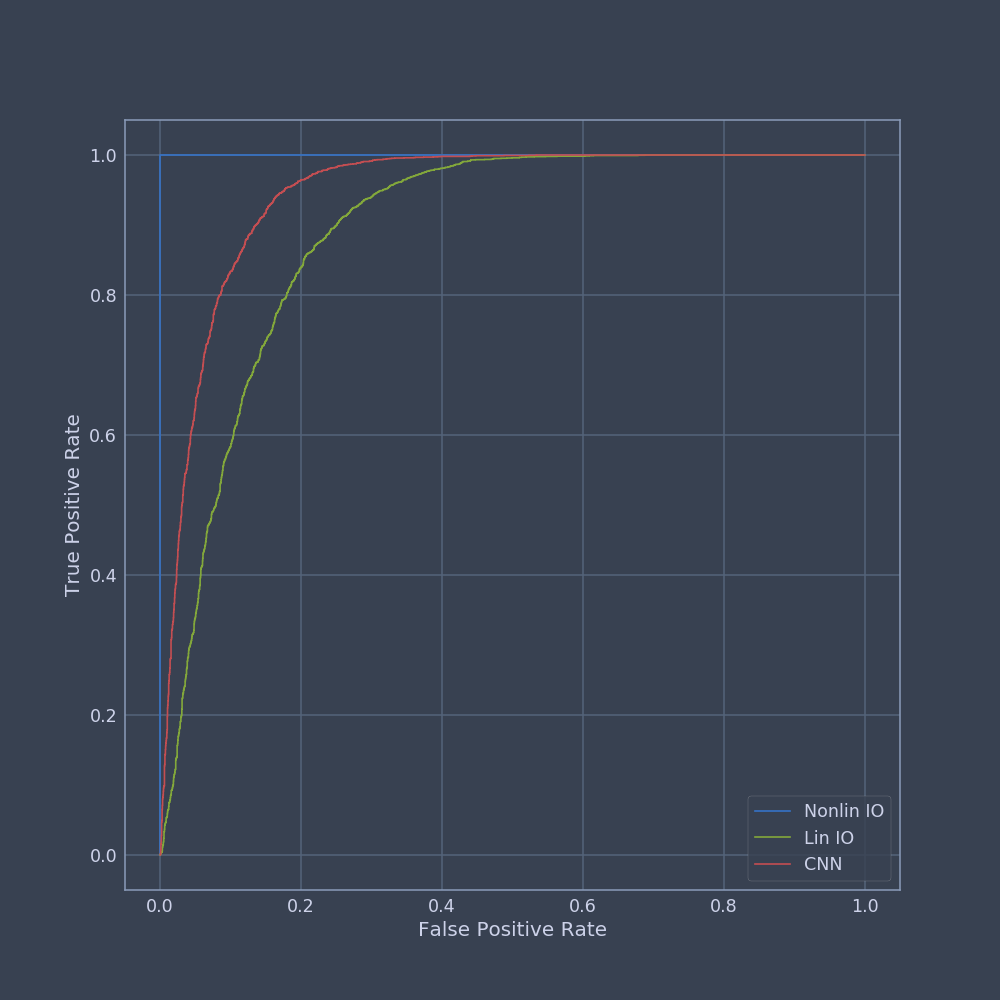

In [5]:
%matplotlib notebook
"""
Assess Performance
"""
# print performance
img_cls = np.array([0]*(val_idx-train_idx) + [1]*(val_idx-train_idx))
[fpr, tpr, _] = roc_curve(img_cls, l_lin)
[fpr_nl, tpr_nl, _] = roc_curve(img_cls, l_nonlin)
[fpr_cnn, tpr_cnn, _] = roc_curve(img_cls, readout_output)
print("lin AUC: {}".format(roc_auc_score(img_cls, l_lin)))
print("nonlin AUC: {}".format(roc_auc_score(img_cls, l_nonlin)))
print("CNN AUC: {}".format(roc_auc_score(img_cls, readout_output)))
plt.figure(figsize=(10, 10))
plt.plot(fpr_nl, tpr_nl, label='Nonlin IO')
plt.plot(fpr, tpr, label='Lin IO')
plt.plot(fpr_cnn, tpr_cnn, label='CNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()